In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))
import time

In [71]:
df = pd.read_csv("input/complaints.csv", usecols=["Product", "Consumer complaint narrative"])

In [72]:
%%time
df.info

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 16 µs


<bound method DataFrame.info of                                                    Product  \
0        Credit reporting, credit repair services, or o...   
1        Credit reporting, credit repair services, or o...   
2        Credit reporting, credit repair services, or o...   
3        Credit reporting, credit repair services, or o...   
4        Credit reporting, credit repair services, or o...   
...                                                    ...   
3390733                                    Debt collection   
3390734                                           Mortgage   
3390735                                   Credit reporting   
3390736                                   Credit reporting   
3390737                                           Mortgage   

                              Consumer complaint narrative  
0                                                      NaN  
1                                                      NaN  
2                                       

In [76]:
df.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1798934
Debt collection                                                                  469132
Mortgage                                                                         372283
Credit card or prepaid card                                                      267434
Checking or savings account                                                      156545
Bank account or service                                                           86206
Student loan                                                                      73314
Money transfer, virtual currency, or money service                                51581
Vehicle loan or lease                                                             40967
Payday loan, title loan, or personal loan                                         32515
Consumer Loan                                                                     31596
Money transfers                 

In [74]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'

In [75]:
df.loc[df.Product == 'Credit card', 'Product'] = 'Credit card or prepaid card'

df.loc[df.Product == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df.Product == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service' 

df = df.loc[df.Product != 'Other financial service']

In [77]:
category_count = df.Product.value_counts()

categories = category_count.index

categories

Index(['Credit reporting, credit repair services, or other personal consumer reports',
       'Debt collection', 'Mortgage', 'Credit card or prepaid card',
       'Checking or savings account', 'Bank account or service',
       'Student loan', 'Money transfer, virtual currency, or money service',
       'Vehicle loan or lease', 'Payday loan, title loan, or personal loan',
       'Consumer Loan', 'Money transfers', 'Prepaid card'],
      dtype='object')

Text(0.5, 1.0, 'No of Complaints by Product')

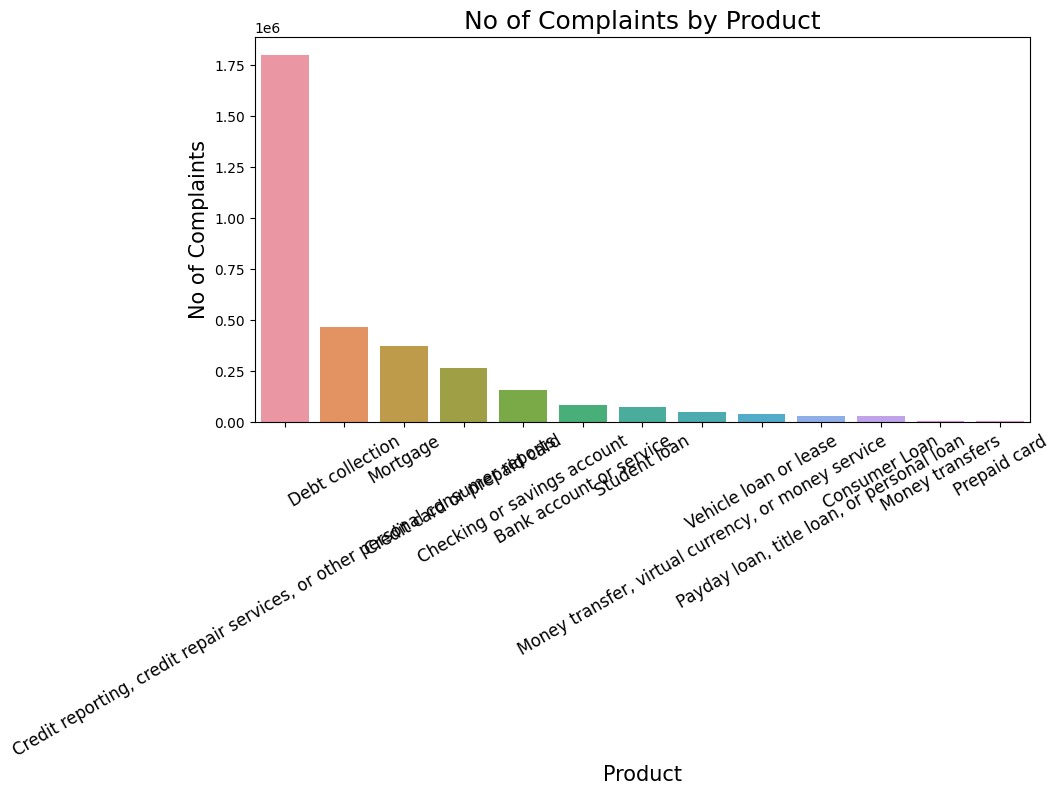

In [78]:
fig = plt.figure(figsize=(10, 5))
sns.barplot(x = category_count.index, y = category_count)

plt.xlabel("Product", size=15)
plt.ylabel("No of Complaints", size=15)
plt.xticks(size=12, rotation=30)
plt.title("No of Complaints by Product", size=18)

In [79]:
df = df.reset_index(drop=True)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(" ", text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text


In [80]:
df['Consumer complaint narrative'] = str(df['Consumer complaint narrative'])

In [81]:
%%timeit
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_text)

14.8 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [82]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')

/var/folders/xf/_6m_tb052fn5p84tlt773rqr0000gn/T/ipykernel_3851/2538235142.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Consumer complaint narrative'] = df['Consumer complaint narrative'].str.replace('\d+', '')


In [83]:
# Max no of word to be used
MAX_NB_WORDS = 50000

# Max no of words in each complaint
MAX_SEQUENCE_LENTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer complaint narrative'].values)

word_index = tokenizer.word_index

print(f'Found {len(word_index)} unique token.')



Found 26 unique token.


In [84]:
X = tokenizer.texts_to_sequences(df['Consumer complaint narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENTH)
print("Shape of Data tensor:", X.shape)

Shape of Data tensor: (3389680, 250)


### Converting categorical labels to numbers

In [85]:
Y = pd.get_dummies(df.Product).values
print("Shape of label tensor: ", Y.shape)

Shape of label tensor:  (3389680, 13)


#### **Train Test Split**

In [86]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2711744, 250) (2711744, 13)
(677936, 250) (677936, 13)


In [87]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

epochs=5
batch_size=64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5


2023-03-05 21:45:59.729767: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  243/38134 [..............................] - ETA: 3:30:27 - loss: 1.6598 - accuracy: 0.5251

KeyboardInterrupt: 

In [ ]:
acc = model.evaluate(X_test, Y_test)
print("Test set\n Loss: {0.03f}\n Accuracy: {:0.3f}".format(acc[0], acc[1]))

In [ ]:
plt.title("Loss")
plt.plot(history.history['Loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.title("Accuracy")
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()